In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.metrics import (classification_report, accuracy_score,
                             precision_recall_fscore_support, confusion_matrix,
                             precision_score, recall_score, roc_auc_score, f1_score)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

DATASET 1

In [38]:

# Define the path to CSV file
csv_path = "/content/drive/MyDrive/diabetes.csv"

data = pd.read_csv(csv_path)

# Show total data's samples
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


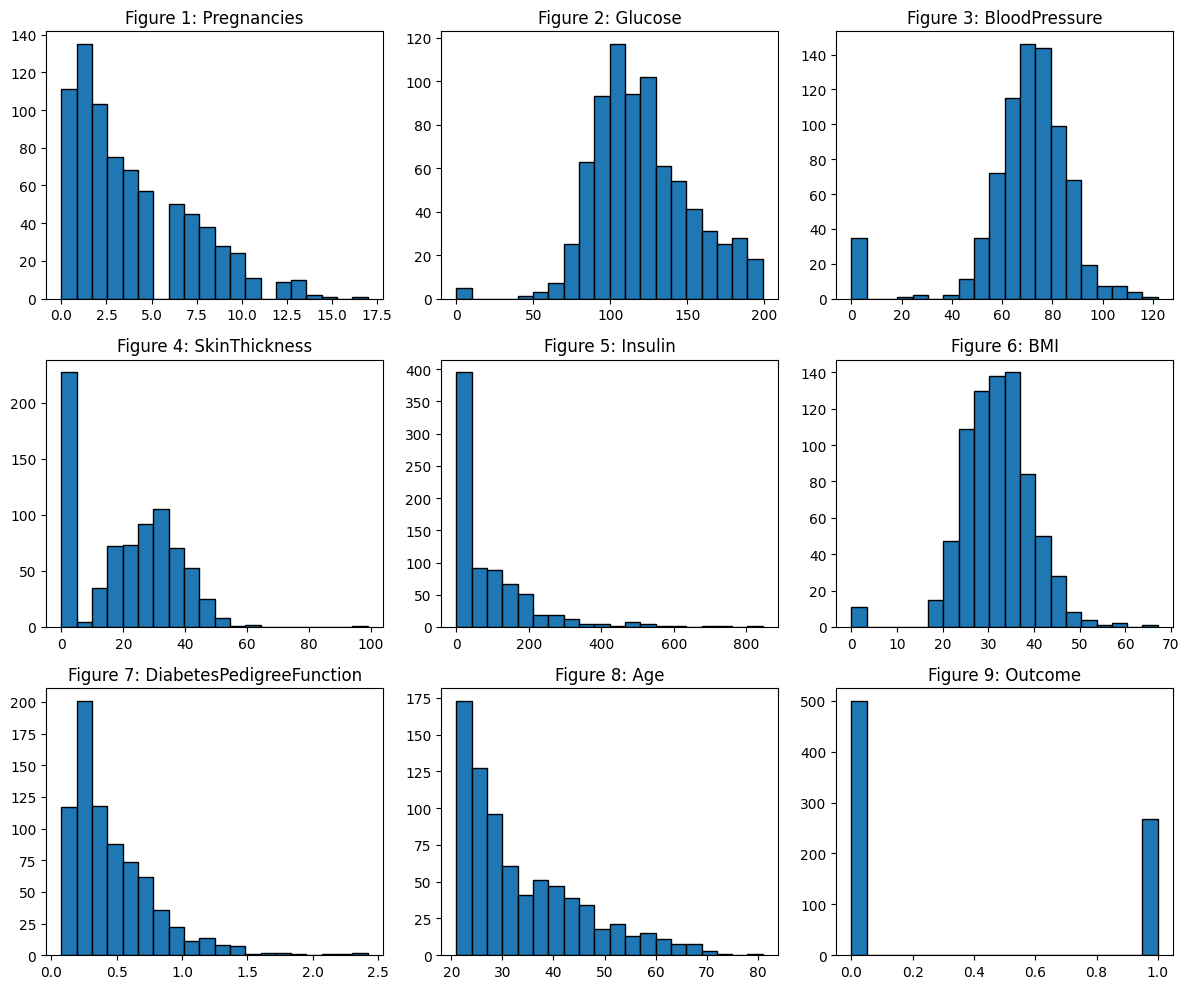

In [ ]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))  # Adjust grid size if needed
axes = axes.flatten()  # Flatten to easily iterate over subplots

# Plot histograms with figure numbers
for i, column in enumerate(data.columns):
    axes[i].hist(data[column], bins=20, edgecolor='black')
    axes[i].set_title(f"Figure {i+1}: {column}")  # Add figure number and column name

# Adjust layout
plt.tight_layout()
plt.show()


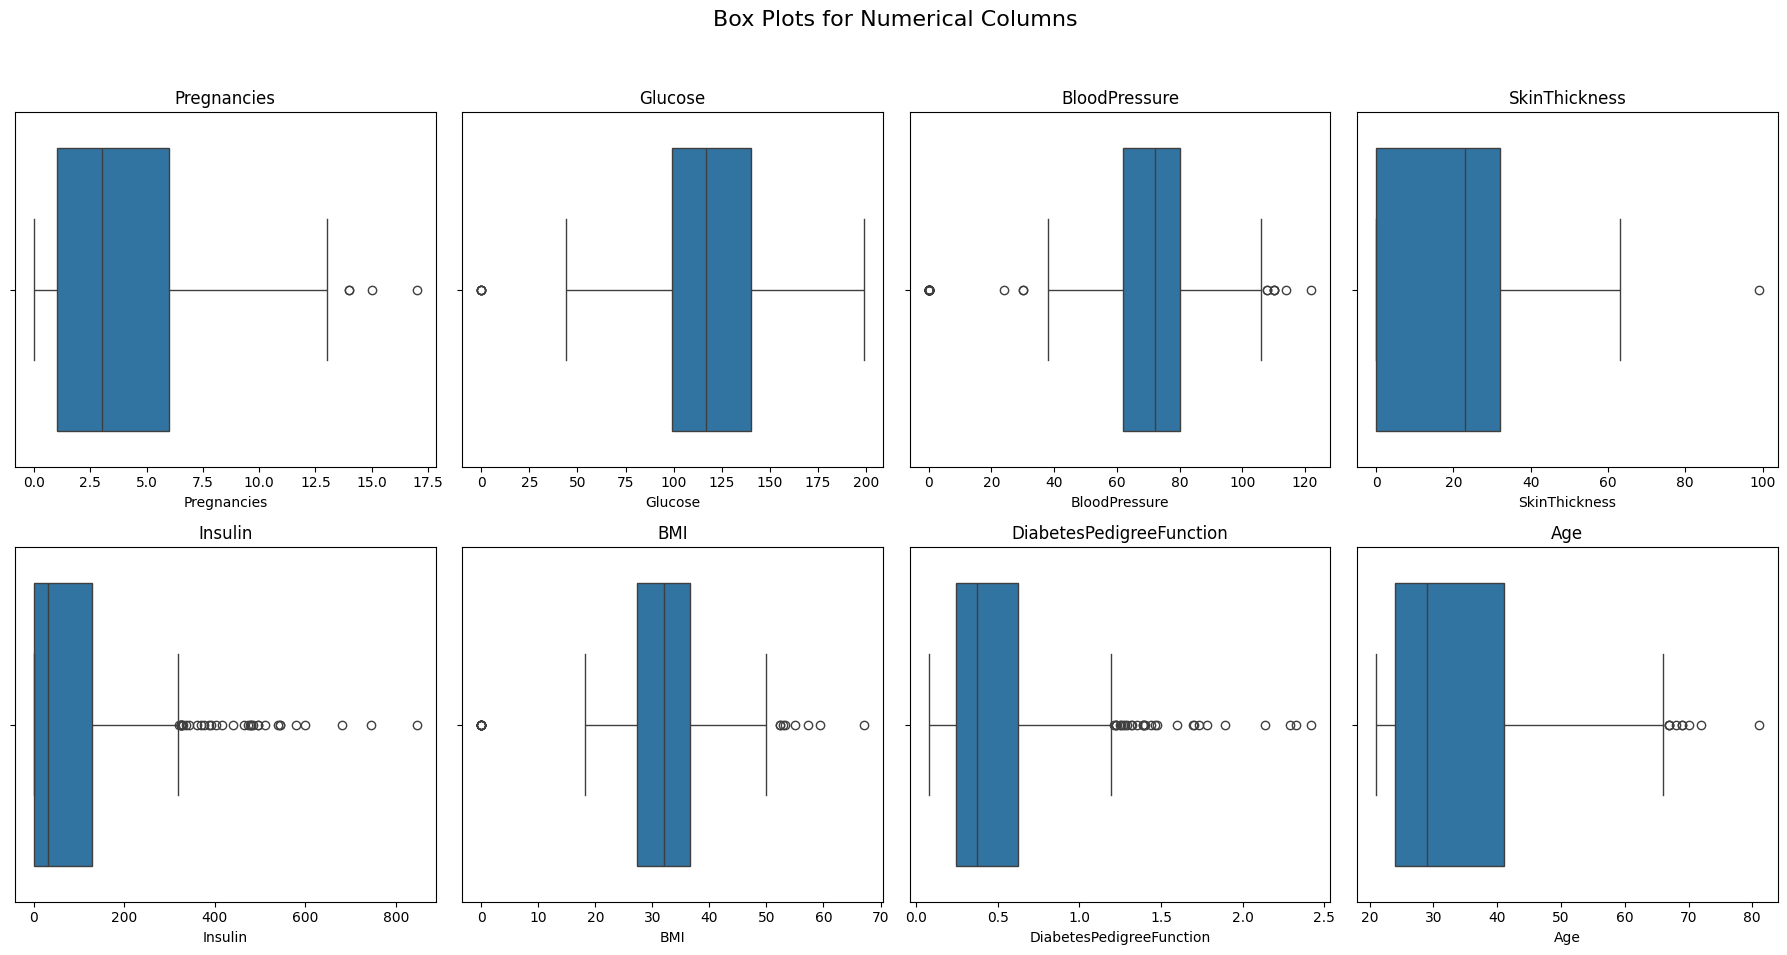

Pregnancies column has 4 outlier out of 768
Glucose column has 5 outlier out of 768
BloodPressure column has 45 outlier out of 768
SkinThickness column has 1 outlier out of 768
Insulin column has 34 outlier out of 768
BMI column has 19 outlier out of 768
DiabetesPedigreeFunction column has 29 outlier out of 768
Age column has 9 outlier out of 768


In [39]:

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Box Plots for Numerical Columns', fontsize=16)


for i, col in enumerate(columns):
    row = i // 4
    col_pos = i % 4
    sns.boxplot(x=data[col], ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'{col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def countOutlier(df,colName):
    Q1 = df[colName].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[colName].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[colName] < lower_bound) | (df[colName] > upper_bound)]

    print(colName,"column has",str(len(outliers)),"outlier out of",len(df[colName]))

for i in columns:
  countOutlier(data,i)

In [ ]:
colWithInvalidZero = ['BloodPressure','Glucose','BMI','SkinThickness','Insulin','Age']

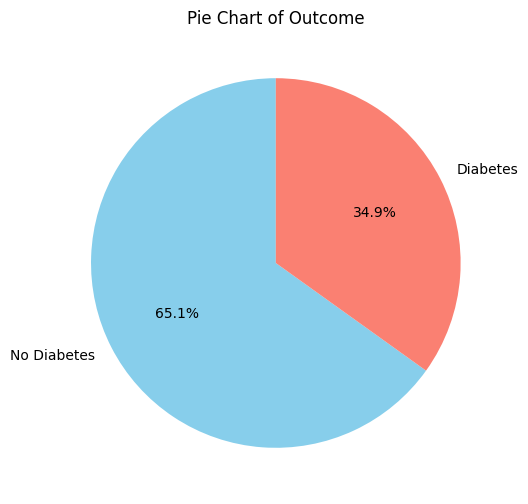

In [ ]:
# Percentage chart
outcome_counts = data['Outcome'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(outcome_counts, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Pie Chart of Outcome')
plt.show()

In [3]:
def countNA(df,columns):
  for col in columns:
    print("There are",str(df[col].isna().sum()),"in",col)

countNA(data,columns)

NameError: name 'data' is not defined

In [ ]:
def count_zero(df,zerocol):
  for col in zerocol:
    print("There are",str((df[col]==0).sum()),"zero value in",col)

count_zero(data,colWithInvalidZero)

In [ ]:
def count_row_with_more_than_one_zero(df, cols):
    mask = (df[cols] == 0).sum(axis=1) > 1  # Count zeros per row
    return mask.sum()  # Count rows where the number of zeros exceeds the threshold

count_row_with_more_than_one_zero(data,colWithInvalidZero)

In [ ]:
def checkBinaryClassfication(df,col):
  count = ((df[col]!=0) & (df[col]!=1)).sum()
  print("There are",str(count),"invalid class in",col)

checkBinaryClassfication(data,"Outcome")

There are 0 invalid class in Outcome


In [4]:
# @title PREPROCESS

# Remove row if there is an outlier
def remove_outliers(df, colName):
    # Calculate the IQR
    Q1 = df[colName].quantile(0.25)
    Q3 = df[colName].quantile(0.75)
    IQR = Q3 - Q1

    # Lower and upper bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows where any value in the column is an outlier
    df_cleaned = df[(df[colName] >= lower_bound) & (df[colName] <= upper_bound)]

    return df_cleaned

# Replace the value if it is a zero
def replace_zero_with_mean(df, colName):
    for col in colName:
        mean_value = df[col].mean()  # Compute mean
        df[col] = df[col].replace(0, mean_value)  # Replace zeros with mean

    return df


def replace_zero_by_regression(df,colName):
  df_reg = df.copy()

  for col in colName:
      non_zero_data = df_reg[df_reg[col] != 0]
      zero_data = df_reg[df_reg[col] == 0]

      if not zero_data.empty:
          model = LinearRegression()
          X_train = non_zero_data.drop(columns=colName)
          y_train = non_zero_data[col]

          X_missing = zero_data.drop(columns=colName)

          model.fit(X_train, y_train)
          df_reg.loc[df_reg[col] == 0, col] = model.predict(X_missing)
  return df_reg

# Split the data into train and test, then apply standard scaler
def split_and_scale_standard(df,classCol):
  # Splitting features and class column
  X = df.drop(columns = classCol)
  y = df[classCol]

  # Spli data into train (80%) and test set (20%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  # Apply SMOTE to training data
  sm = SMOTE(random_state=42)
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

  # Apply StandardScaler
  scaler = StandardScaler()
  X_train_resampled = scaler.fit_transform(X_train_resampled)
  X_test = scaler.transform(X_test)

  return X_train_resampled, X_test, y_train_resampled, y_test

def split_and_scale_robust(df,classCol):
  # Splitting features and class column
  X = df.drop(columns = classCol)
  y = df[classCol]

  # Spli data into train (80%) and test set (20%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  # Apply SMOTE to training data
  sm = SMOTE(random_state=42)
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

  # Apply RobustSclaer
  scaler = RobustScaler()
  X_train_resampled = scaler.fit_transform(X_train_resampled)
  X_test = scaler.transform(X_test)

  return X_train_resampled, X_test, y_train_resampled, y_test

def split_and_scale_minmax(df,classCol):
  # Splitting features and class column
  X = df.drop(columns = classCol)
  y = df[classCol]

  # Spli data into train (80%) and test set (20%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  # Apply SMOTE to training data
  sm = SMOTE(random_state=42)
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

  # Apply MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0,1))
  X_train_resampled = scaler.fit_transform(X_train_resampled)
  X_test = scaler.transform(X_test)

  return X_train_resampled, X_test, y_train_resampled, y_test

In [ ]:
# for col in colWithInvalidZero:
#   df_removeOutlier = replace_zero_with_median(df_removeOutlier,col)
#   df_replaceOutlier = replace_zero_with_median(df_replaceOutlier,col)

df = data.copy()

df_replace = replace_zero_by_regression(df,colWithInvalidZero)

<ipython-input-6-89d6397796d2>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[75.63384286 76.77960533 73.47683718 70.10213755 72.21879464 70.25774101
 69.74086022 79.40757175 73.55078733 73.86585236 71.70807636 73.59209204
 71.78048589 72.88464486 68.2681923  70.8673583  80.76469255 68.78892466
 70.25311913 72.26886506 69.69541169 77.68656387 71.94148155 70.87737238
 72.89109963 72.65076162 74.89452054 68.72267764 72.89032932 74.96384881
 72.31816517 71.2166094  68.7912356  70.10213755 78.97666734]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_reg.loc[df_reg[col] == 0, col] = model.predict(X_missing)
<ipython-input-6-89d6397796d2>:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[108.63277509 109.44488475 109.90456947 141.30618323 143.47991976]' has dtype incompatible wit

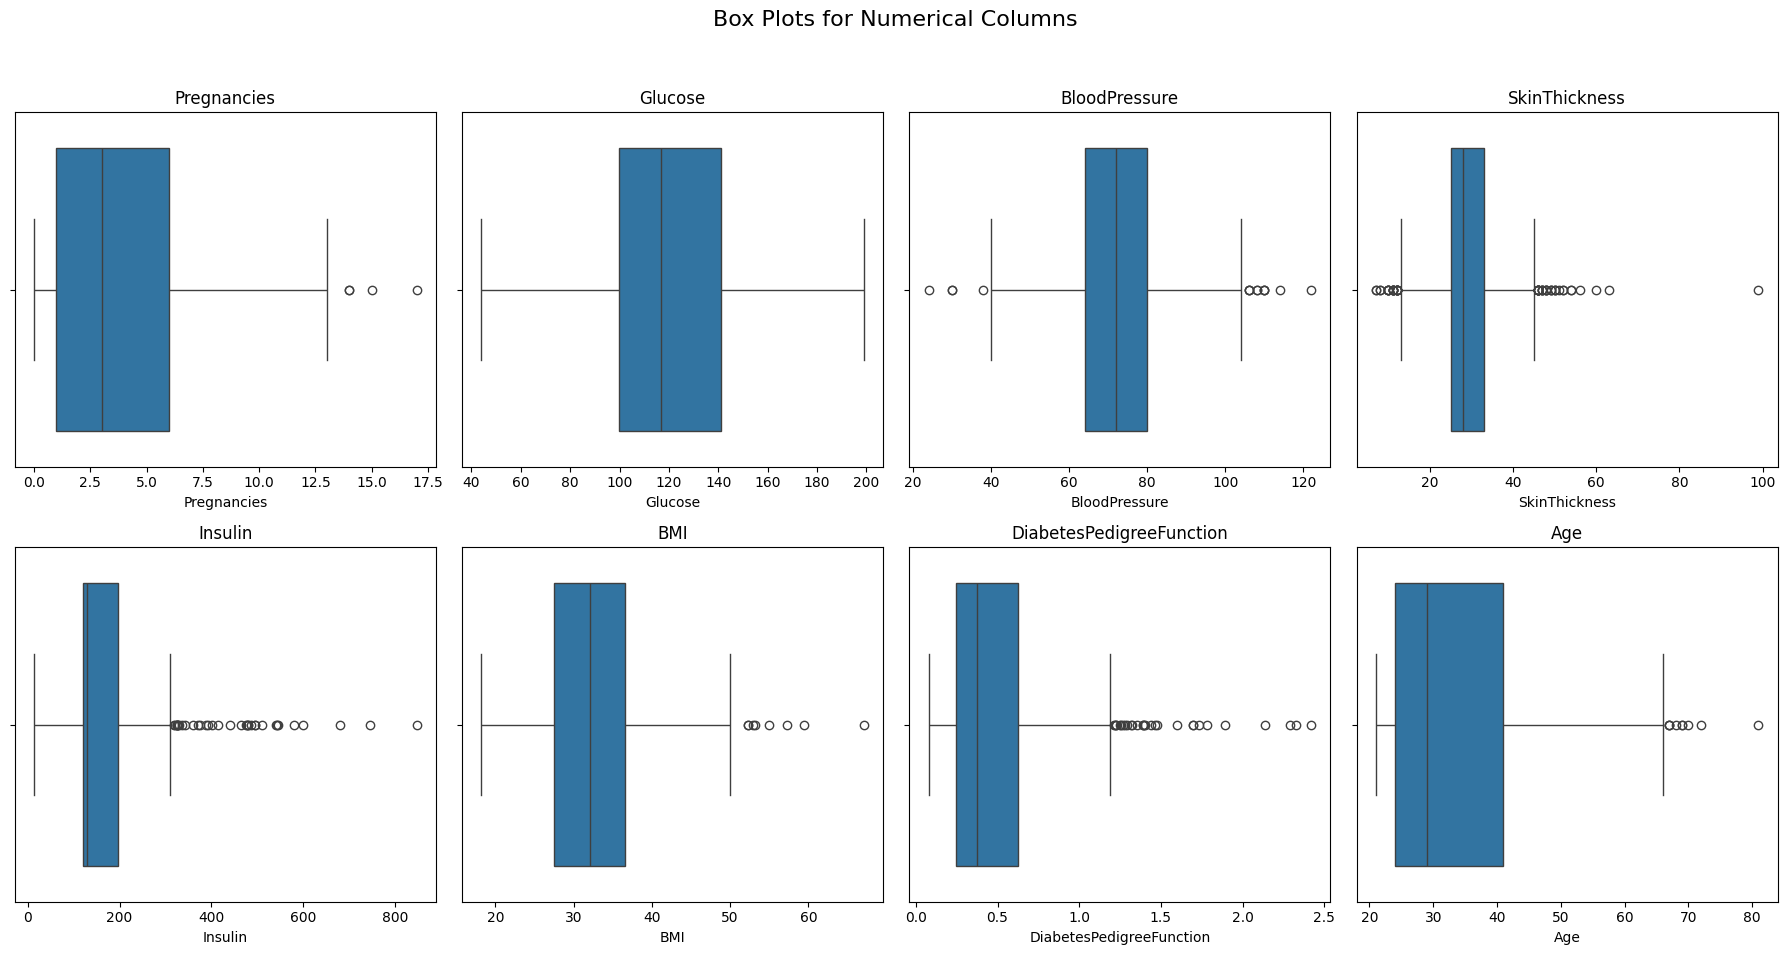

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Box Plots for Numerical Columns', fontsize=16)


for i, col in enumerate(columns):
    row = i // 4
    col_pos = i % 4
    sns.boxplot(x=df_replace[col], ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'{col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
for col in columns:
  countOutlier(df_replace,col)

Pregnancies column has 4 outlier out of 768
Glucose column has 0 outlier out of 768
BloodPressure column has 14 outlier out of 768
SkinThickness column has 53 outlier out of 768
Insulin column has 35 outlier out of 768
BMI column has 8 outlier out of 768
DiabetesPedigreeFunction column has 29 outlier out of 768
Age column has 9 outlier out of 768


In [ ]:

for col in columns:
  df_removeOutlier = remove_outliers(df_replace,col)

# data used remove outlier
X_train_remove_std, X_test_remove_std, y_train_remove_std, y_test_remove_std = split_and_scale_standard(df_removeOutlier,"Outcome")
X_train_remove_rb, X_test_remove_rb, y_train_remove_rb, y_test_remove_rb = split_and_scale_robust(df_removeOutlier,"Outcome")
X_train_remove_mm, X_test_remove_mm, y_train_remove_mm, y_test_remove_mm = split_and_scale_minmax(df_removeOutlier,"Outcome")

In [ ]:


def predict_n_times(n,X_train_remove,y_train_remove,X_test_remove,y_test_remove):
  # Store accuracy result
  result = []

  # Train and predict n times
  for i in range (n):
    # Train model
    model = SVC()
    model.fit(X_train_remove, y_train_remove)

    # Predict with the model
    y_pred = model.predict(X_test_remove)
    accuracy = accuracy_score(y_pred,y_test_remove)

    result.append(accuracy)
    print("Run #" + str(i+1) + ":",str(accuracy))

  result = np.array(result)
  print("Average accuracy: ",str(result.mean()))

In [ ]:
predict_n_times(10,X_train_remove_rb,y_train_remove_rb,X_test_remove_rb,y_test_remove_rb)

Run #1: 0.8026315789473685
Run #2: 0.8026315789473685
Run #3: 0.8026315789473685
Run #4: 0.8026315789473685
Run #5: 0.8026315789473685
Run #6: 0.8026315789473685
Run #7: 0.8026315789473685
Run #8: 0.8026315789473685
Run #9: 0.8026315789473685
Run #10: 0.8026315789473685
Average accuracy:  0.8026315789473685


TRY WITH DEEP LEARNING MODEL

In [ ]:
callbacks = [
    ModelCheckpoint("bestmodel.keras", monitor='val_accuracy', save_best_only=True)
]

In [ ]:
model = Sequential()
model.add(Dense(150, input_dim=8, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(100, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(25, activation="relu"))
# model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train_deep,y_train_deep,batch_size=32,epochs=75,validation_data=(X_test_deep,y_test_deep),callbacks=callbacks)

Epoch 1/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6041 - loss: 0.6539 - val_accuracy: 0.7013 - val_loss: 0.6001
Epoch 2/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7520 - loss: 0.5032 - val_accuracy: 0.7403 - val_loss: 0.5317
Epoch 3/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7300 - loss: 0.5011 - val_accuracy: 0.7273 - val_loss: 0.5425
Epoch 4/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7524 - loss: 0.4627 - val_accuracy: 0.7403 - val_loss: 0.5286
Epoch 5/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7881 - loss: 0.4368 - val_accuracy: 0.7857 - val_loss: 0.5216
Epoch 6/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7888 - loss: 0.4195 - val_accuracy: 0.7273 - val_loss: 0.5805
Epoch 7/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7942 - loss: 0.4175 - val_accuracy: 0.7468 - val_loss: 0.5414
Epoch 8/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8300 - loss: 0.3852 - val_accuracy: 0.7468 - val_loss

In [ ]:


def visualizeTraining(history1):
  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history1.history['accuracy'], label='Train Accuracy')
  plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='best')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history1.history['loss'], label='Train Loss')
  plt.plot(history1.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')

  plt.show()

def confusionMatrix(model, x_test, y_test, class_labels):
    y_pred_prob = model.predict(x_test)  # Sigmoid probabilities
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels (0 or 1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(y_test, y_pred, target_names=class_labels))

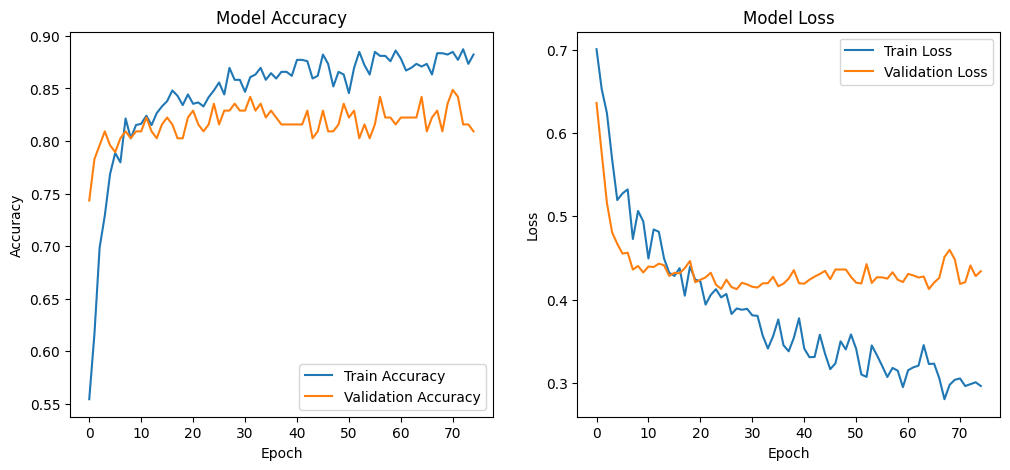

In [ ]:
visualizeTraining(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


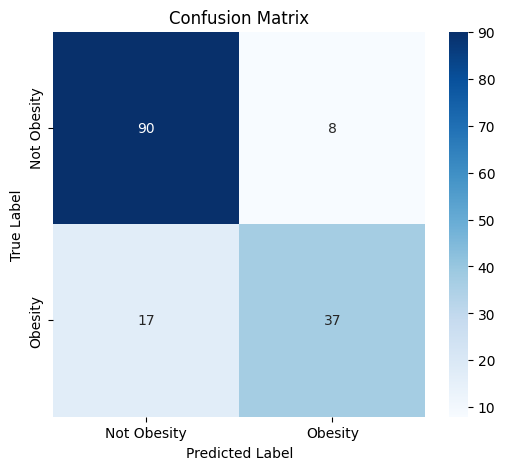

              precision    recall  f1-score   support

 Not Obesity       0.84      0.92      0.88        98
     Obesity       0.82      0.69      0.75        54

    accuracy                           0.84       152
   macro avg       0.83      0.80      0.81       152
weighted avg       0.83      0.84      0.83       152



In [ ]:
confusionMatrix(model,X_test_remove_rb,y_test_remove_rb,["Not Obesity","Obesity"])

DATASET 2

In [57]:

# Define the path to CSV file
csv_path = "/content/drive/MyDrive/diabetes2.csv"

# Read the CSV, parse 'Date' column as datetime, and set it as the index
data2 = pd.read_csv(csv_path)

# Show total data's samples
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


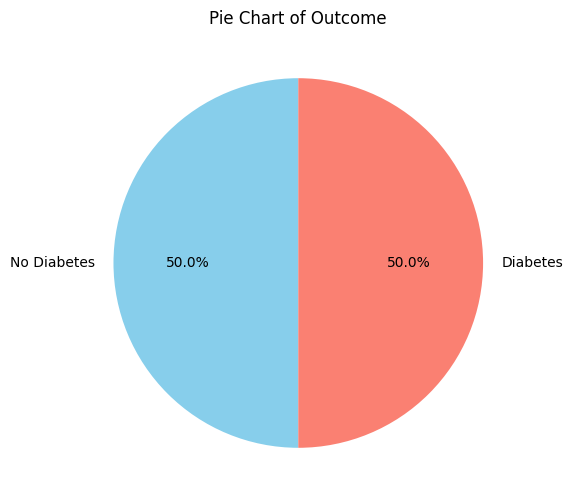

In [6]:


# Percentage chart
outcome_counts = data2['Diabetes_binary'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(outcome_counts, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Pie Chart of Outcome')
plt.show()

In [54]:
columns2 = ["HighBP","HighChol","CholCheck","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity","Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare","NoDocbcCost","GenHlth","MentHlth","PhysHlth","DiffWalk","Sex","Age","Education","Income"]
class_col2 = ["Diabetes_binary"]
numeric_cols2 = ["BMI","MentHlth","PhysHlth"]

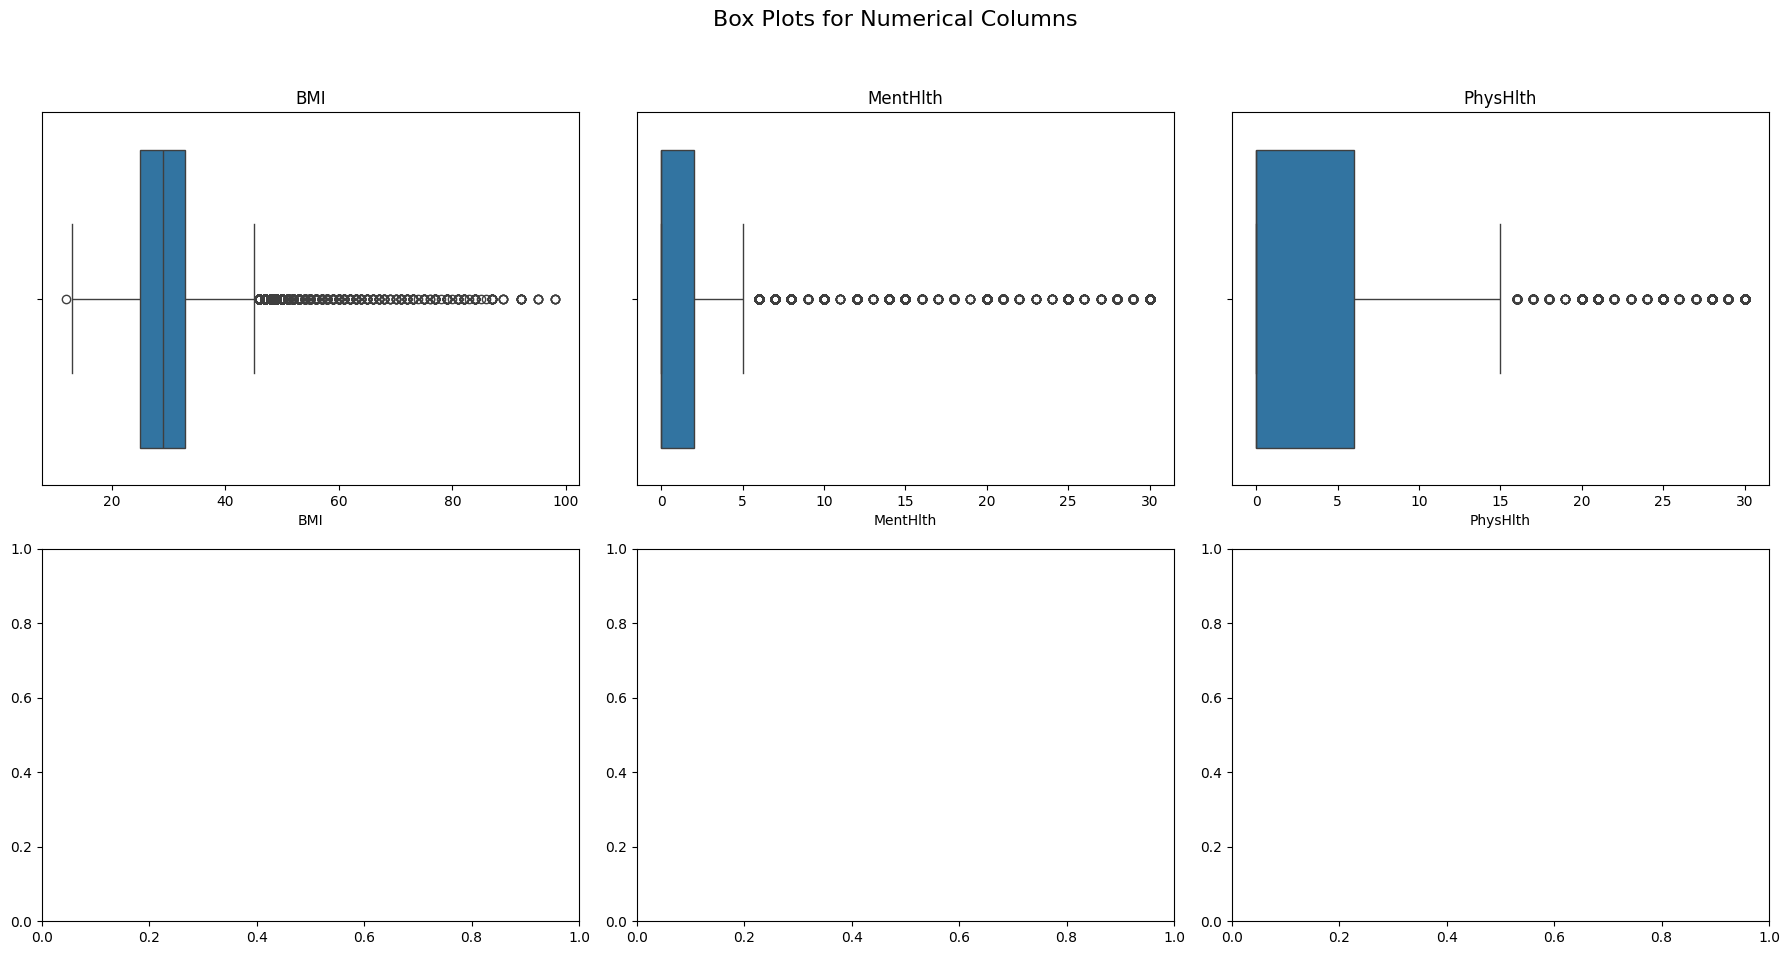

In [8]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Box Plots for Numerical Columns', fontsize=16)


for i, col in enumerate(numeric_cols2):
    row = 0
    col_pos = i
    sns.boxplot(x=data2[col], ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'{col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [55]:
for col in numeric_cols2:
  countOutlier(data2,col)

BMI column has 2181 outlier out of 70692
MentHlth column has 11816 outlier out of 70692
PhysHlth column has 10624 outlier out of 70692


In [58]:
countNA(data2,columns2)

There are 0 in HighBP
There are 0 in HighChol
There are 0 in CholCheck
There are 0 in BMI
There are 0 in Smoker
There are 0 in Stroke
There are 0 in HeartDiseaseorAttack
There are 0 in PhysActivity
There are 0 in Fruits
There are 0 in Veggies
There are 0 in HvyAlcoholConsump
There are 0 in AnyHealthcare
There are 0 in NoDocbcCost
There are 0 in GenHlth
There are 0 in MentHlth
There are 0 in PhysHlth
There are 0 in DiffWalk
There are 0 in Sex
There are 0 in Age
There are 0 in Education
There are 0 in Income


In [59]:
print("Total duplicated row:",data2.duplicated().sum())

Total duplicated row: 1635


PREPROCESS

In [60]:
df2 = data2.copy()

df2.drop_duplicates(inplace=True)

print("Total duplicated row:",df2.duplicated().sum())

Total duplicated row: 0


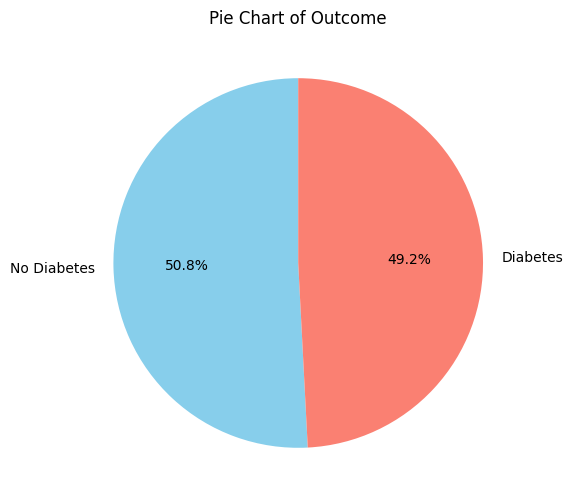

In [61]:


# Percentage chart
outcome_counts = df2['Diabetes_binary'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(outcome_counts, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Pie Chart of Outcome')
plt.show()

In [62]:
for col in numeric_cols2:
  df2_removed = remove_outliers(df2,col)

In [64]:
X = df2_removed[columns2]
y = df2_removed[class_col2]

X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,test_size=0.2,random_state=42)

In [65]:


def predict_n_times_2nd(n,X_train_remove,y_train_remove,X_test_remove,y_test_remove):
  # Store accuracy result
  result = []

  # Train and predict n times
  for i in range (n):
    # Train model
    model = RandomForestClassifier() # DecisionTreeClassifier, SVC, RandomForestClassifier, KNeighborsClassifier
    model.fit(X_train_remove, y_train_remove)

    # Predict with the model
    y_pred = model.predict(X_test_remove)
    accuracy = accuracy_score(y_pred,y_test_remove)

    result.append(accuracy)
    print("Run #" + str(i+1) + ":",str(accuracy))

  result = np.array(result)
  print("Average accuracy: ",str(result.mean()))

In [66]:
predict_n_times_2nd(10,X_train2, y_train2, X_test2, y_test2)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #1: 0.7263004791238877


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #2: 0.7256160164271047


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #3: 0.7274127310061602


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #4: 0.7279260780287474


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #5: 0.7257871321013005


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #6: 0.7287816563997263


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #7: 0.7265571526351814


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #8: 0.7287816563997263


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #9: 0.7249315537303217


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Run #10: 0.7287816563997263
Average accuracy:  0.7270876112251883


In [21]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("Bestmodel.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]

In [72]:
model2 = Sequential()
model2.add(Dense(256, input_dim=len(columns2), activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))

model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=Adam(learning_rate=1e-4))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
history2 = model2.fit(X_train2,y_train2,batch_size=32,epochs=75,validation_data=(X_test2,y_test2),callbacks=callbacks)

Epoch 1/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4979 - loss: 1.2769 - val_accuracy: 0.5266 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 2/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5078 - loss: 0.7300 - val_accuracy: 0.5266 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 3/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5231 - loss: 0.7019 - val_accuracy: 0.5266 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 4/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5410 - loss: 0.6946 - val_accuracy: 0.5266 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 5/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5607 - loss: 0.6869 - val_accuracy: 0.5395 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 6/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5920 - loss: 0.6766 - val_accuracy: 0.5963 - val_loss: 0.6689 - learning_rate: 1.0000e-04
Epoch 7/75
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 11s 6